# Transformation Equations:  DES <--> ComCam 

_Meagan N. Porter_

_2025.3.25_

## Initial Setup

In [1]:
import numpy as np
import pandas as pd

import os
import sys
import glob
import math
import datetime

from collections import OrderedDict as odict

from astropy.io import fits
from astropy.table import Table

import fitsio

from scipy import interpolate
from scipy.optimize import leastsq

import healpy as hp

import plotly
from plotly.offline import download_plotlyjs, plot, iplot
import plotly.graph_objs as go

import matplotlib.pyplot as plt

%matplotlib inline

## Input Parameters

In [2]:
# List of bands on which to run the transform fit...
#bandList = ['g']
bandList = ['u','g', 'r', 'i', 'z']
#bandList = ['i', 'z']
            
# DES-->LSST (toLSST=True) or LSST-->DES (toLSST=False)...
toLSST = True
#toLSST = False


# Color to fit against...
color_name_1 = 'gi'
#color_name_1 = 'iz'


# Name of color_name_1 as the label in the QA plots...
colorLabel_1 = '(g-i)'
#colorLabel_1 = '(i-z)'


if toLSST:
    # If DES-->LSST, then the color to fit against and its plot label are DES...
    color_name_1 = """%s_des""" % (color_name_1)
    colorLabel_1 = """$%s_{des}$""" % colorLabel_1   
else:
    # If LSST-->DES, then the color to fit against and its plot label are LSST...
    color_name_1 = """%s_lsst""" % (color_name_1)
    colorLabel_1 = """$%s_{lsst}$""" % colorLabel_1      


# Order of polynomial fits...
norder = 2

# Sigma-clipping parameters...
nsigma = 3.0
niter = 3

# Identify directory containing the LSST/DES Pickles synthetic photometry files...
# (let this point to the directory where you have placed the Pickles synthetic photometry files)
synthDir = '/home/m/meaganp/DATA/thesis_work'
# Name of the LSST Pickles synthetic photometry file...
synthFile_1 = 'synthMagColorList.lsst_v1.9.csv'
# Name of the DES Pickles synthetic photometry file...
synthFile_2 = 'synthMagColorList.des.csv' 


# Base name of fit results output file...
if toLSST:
    #resultsFileBaseName = 'transFit.des_to_lsst'
    resultsFileBaseName = 'transFit.des_to_lsst_g'
else:
    #resultsFileBaseName = 'transFit.lsst_to_des'
    resultsFileBaseName = 'transFit.lsst_to_des_g'

    
# Base name of QA plot output files...
if toLSST:
    qaFileBaseName = 'qaPlot.des_to_lsst.fit'
else:
    qaFileBaseName = 'qaPlot.lsst_to_des.fit'
    

# Verbosity level (0, 1, 2, 3, ...)
verbose = 2

## Define Some Modules

In [3]:
##################################
#
# Define some functions for fitting dmag vs. color...
#
# These functions are based on a scripts found at 
# http://linuxgazette.net/115/andreasen.html (by Anders Andreasen)
# and at
# http://www.phy.uct.ac.za/courses/python/examples/fitresonance.py (University of Cape Town)


##################################

# Parametric function:  
#  p is the parameter vector; 
#  For fp1, we assume a polynomial function in one color...
def fp1(p,color1_array):
    #retValue = p[0] + p[1]*color1_array + p[2]*color1_array*color1_array
    norder = p.size-1
    retValue = p[0]
    for i in range(norder):
        retValue = retValue + p[i+1]*color1_array**(i+1)
    return retValue


##################################

# Error function:
def residuals1(p,color1_array,dmag_array):
    err = (dmag_array-fp1(p,color1_array))
    return err


##################################

# Fitting code:
def transformFit1(color1_array, dmag_array, norder=2, verbose=0):

    # Calculate the median of dmag for use as an initial guess
    # for the overall zeropoint offset..
    mdn = np.median( dmag_array, None )

    # Parameter names
    #pname = (['c_0', 'c_1', 'c_2'])
    pname = []
    for i in range(0,norder+1):
        pname.append("""c_%d""" % i)

    # Initial parameter values
    #p0 = [mdn, 0.0, 0.0]
    p0 = (1+norder)*[0.0]
    p0[0] = mdn

    if verbose > 0:
        print('') 
        print('Initial parameter values:  ', p0)

    # Perform fit

    p,cov,infodict,mesg,ier = leastsq(residuals1, p0, 
                                      args=(color1_array, dmag_array), 
                                      maxfev=10000, full_output=1)

    if ( ier>=1 and ier <=4):
        if verbose > 0:  print("Converged")
    else:
        # Add an exception error or a non-zero return value?
        print("Not converged")
        print(mesg)


    # Calculate some descriptors of the fit 
    # (similar to the output from gnuplot 2d fits)

    chisq=sum(infodict['fvec']*infodict['fvec'])
    dof=len(dmag_array)-len(p)
    rms=math.sqrt(chisq/dof)
    
    if verbose > 0:
        print("Converged with chi squared ",chisq)
        print("degrees of freedom, dof ", dof)
        print("RMS of residuals (i.e. sqrt(chisq/dof)) ", rms)
        print("Reduced chisq (i.e. variance of residuals) ", chisq/dof)
        print('')


    # uncertainties are calculated as per gnuplot, "fixing" the result
    # for non unit values of the reduced chisq.
    # values at min match gnuplot
    perr = []
    if verbose > 0:  
        print("Fitted parameters at minimum, with 68% C.I.:")
    for i,pmin in enumerate(p):
        if verbose > 0:  
            print("%-10s %13g +/- %13g   (%5f percent)" % (pname[i],pmin,math.sqrt(cov[i,i])*math.sqrt(chisq/dof),
                                                           100.*math.sqrt(cov[i,i])*math.sqrt(chisq/dof)/abs(pmin)))
        perr.append(math.sqrt(cov[i,i])*math.sqrt(chisq/dof))
    if verbose > 0: print('')

    if verbose > 0:
        print("Correlation matrix:")
        # correlation matrix close to gnuplot
        print("               ",)
        for i in range(len(pname)): print("%-10s" % (pname[i],),)
        print('')
        for i in range(len(p)):
            print("%-10s" % pname[i],)
            for j in range(i+1):
                print("%10f" % (cov[i,j]/math.sqrt(cov[i,i]*cov[j,j]),),)
            #endfor
            print('')
        #endfor
        print('')
        print('')
        print('')
    
    return p, perr, rms


In [4]:
##################################

def createFitResultsOutputLine(norder, p, perr, rms, dmag_name, color1_name, color2_name=''):

    outputList = (2*(2*norder+1)+4)*[-9999.]
    outputList[0] = dmag_name
    outputList[1] = color1_name
    outputList[2] = color2_name
    for j in range(p.size):
        outputList[2*j+3] = p[j]
        outputList[2*j+4] = perr[j]
    outputList[2*(2*norder+1)+3] = rms
    outputLine = ','.join(map(str, outputList))
    return outputLine


##################################

def createFitResultsHeaderOutputLine(norder):

    outputList = (2*(2*norder+1)+4)*['c_']
    outputList[0] = 'dmag_name'
    outputList[1] = 'color1_name'
    outputList[2] = 'color2_name'
    for j in range(2*norder+1):
        outputList[2*j+3] = ("""c_%d""" % j)
        outputList[2*j+4] = ("""cerr_%d""" % j)
    outputList[2*(2*norder+1)+3] = 'rms'
    outputLine = ','.join(map(str, outputList))
    return outputLine


##################################

def transform1ColorQAPlots1(dmag, color1, res, norder, title, dmagName, colorLabel1, p, rms, outputFileName):

    # Prepare QA plots...
    #fig = plt.figure(figsize=(10,5))
    #fig = plt.figure(figsize=(40,20))
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.3)
    #fig.suptitle("This is a supertitle!")
    plt.rcParams.update({'font.size': 24})
    
    
    # We will exclude the lowest and highets 0.01% of color1, color2, 
    #  dmag, and residuals when plotting the QA figures...
    color1_desc = color1.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    dmag_desc = dmag.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #res_desc = df.res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    res_desc = res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #color1_min = color1_desc['1%']
    #color1_max = color1_desc['99%']
    #color1_min = color1_desc['min']
    #color1_max = color1_desc['max']
    #dmag_min = dmag_desc['1%']
    #dmag_max = dmag_desc['99%']
    #res_min = res_desc['1%']
    #res_max = res_desc['99%']
    color1_min = color1_desc['0.01%']
    color1_max = color1_desc['99.99%']
    dmag_min = dmag_desc['0.01%']
    dmag_max = dmag_desc['99.99%']
    res_min = res_desc['0.01%']
    res_max = res_desc['99.99%']


    # Plot 1:  Descriptive text...
    #plt.subplot(231)
    plt.subplot(221)
    if norder == 1:
        plot1Text = """%s \n\n%s = \n %.3f + \n %.3f*%s \n\n [rms: %.3f] \n\n [%.1f < %s < %.1f]""" % \
            (title, dmagName, p[0], p[1], colorLabel1, rms, color1_desc['min'], colorLabel1, color1_desc['max'])
    elif norder == 2:
        plot1Text = """%s \n\n%s = \n %.3f + \n %.3f*%s + \n %.3f*%s^2 \n\n [rms: %.3f] \n\n [%.1f < %s < %.1f]""" % \
            (title, dmagName, p[0], p[1], colorLabel1, p[2], colorLabel1, rms, color1_desc['min'], colorLabel1, color1_desc['max'])
    else:
        plot1Text = ''
    #plt.text(0.1,0.25,plot1Text)
    plt.text(0.1,0.00,plot1Text)
    plt.axis('off')

    
    # Plot 2:  2D hexbin histogram of dmag vs. color1...
    #plt.subplot(232) 
    plt.subplot(222)
    hb=plt.hexbin(color1, dmag, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, dmag_min, dmag_max])
    plt.xlabel(colorLabel1)
    plt.ylabel(dmagName)
    cb = fig.colorbar(hb)
    #cb.set_label('Number')
    cb.set_label('log10(N)')
    plt.grid(color='white')
    plt.grid(True)

    
    # Plot 3:  1d histogram of residuals...
    #plt.subplot(234) 
    plt.subplot(223) 
    #plt.hist(df.loc[:,'res'],bins=100)
    plt.hist(res,bins=100)
    plt.xlabel('residuals [mag]')
    plt.ylabel('Number')
    plt.grid(True)
    plt.grid(color='black')

    
    # Plot 4:  2d hexbin histogram of residuals vs. color1...
    #plt.subplot(235) 
    plt.subplot(224) 
    #hb = plt.hexbin(color1, df.loc[:,'res'], gridsize=100, cmap='inferno')
    hb = plt.hexbin(color1, res, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, res_min, res_max])
    plt.xlabel(colorLabel1)
    plt.ylabel('residuals [mag]')
    cb = plt.colorbar(hb)
    #cb.set_label('Number')
    cb.set_label('log10(N)')
    plt.grid(True)
    plt.grid(color='white')


    # Plot...
    plt.tight_layout()
    #plt.show()
    plt.savefig(outputFileName)

    return 0


##################################


## Create Matched Catalog

In [5]:
# Identify LSST synthetic photometry file...
synthFile_1 = os.path.join(synthDir,synthFile_1)

# Check to make sure synthFile_1 exists...
if os.path.isfile(synthFile_1)==False:
    print("""ERROR:  synthFile_1 %s does not exist...""" % (synthFile_1))
if verbose > 0:
    print('synthFile_1: ', synthFile_1)

synthFile_1:  /home/m/meaganp/DATA/thesis_work/synthMagColorList.lsst_v1.9.csv


In [6]:
# Read LSST synthetic photometry file into a pandas dataframe...
df_1 = pd.read_csv(synthFile_1)
df_1.head()

,fileName,baseName,objShortName,sum,u,g,r,i,z,y,ug,gr,ri,iz,zy
0,pickles_uk_100.lsst_v1.9.mag.csv,pickles_uk_100,100,NaN,2.7986,0.5952,-0.4568,-2.0947,-2.8499,-3.2992,2.2034,1.0520,1.6379,0.7552,0.4493
1,pickles_uk_101.lsst_v1.9.mag.csv,pickles_uk_101,101,NaN,2.4519,0.5641,-0.5083,-2.4895,-3.4425,-4.0401,1.8878,1.0724,1.9812,0.9530,0.5976
2,pickles_uk_102.lsst_v1.9.mag.csv,pickles_uk_102,102,NaN,1.7605,0.5276,-0.6372,-2.9829,-4.2498,-5.0491,1.2329,1.1648,2.3457,1.2669,0.7993
3,pickles_uk_103.lsst_v1.9.mag.csv,pickles_uk_103,103,NaN,1.3341,0.5768,-0.7719,-3.1919,-4.7814,-5.9045,0.7573,1.3487,2.4200,1.5895,1.1231
4,pickles_uk_104.lsst_v1.9.mag.csv,pickles_uk_104,104,NaN,1.3066,0.5411,-0.6321,-2.9439,-4.5113,-5.7044,0.7655,1.1732,2.3118,1.5674,1.1931


In [7]:
# Update column names so that they all have a suffix of "_lsst"...
suffix_1 = '_lsst'
# Create a dictionary mapping old column names to new column names
new_columns_1 = {col: col + suffix_1 for col in df_1.columns}
# Rename the columns
df_1 = df_1.rename(columns=new_columns_1)
df_1.head()

,fileName_lsst,baseName_lsst,objShortName_lsst,sum_lsst,u_lsst,g_lsst,r_lsst,i_lsst,z_lsst,y_lsst,ug_lsst,gr_lsst,ri_lsst,iz_lsst,zy_lsst
0,pickles_uk_100.lsst_v1.9.mag.csv,pickles_uk_100,100,NaN,2.7986,0.5952,-0.4568,-2.0947,-2.8499,-3.2992,2.2034,1.0520,1.6379,0.7552,0.4493
1,pickles_uk_101.lsst_v1.9.mag.csv,pickles_uk_101,101,NaN,2.4519,0.5641,-0.5083,-2.4895,-3.4425,-4.0401,1.8878,1.0724,1.9812,0.9530,0.5976
2,pickles_uk_102.lsst_v1.9.mag.csv,pickles_uk_102,102,NaN,1.7605,0.5276,-0.6372,-2.9829,-4.2498,-5.0491,1.2329,1.1648,2.3457,1.2669,0.7993
3,pickles_uk_103.lsst_v1.9.mag.csv,pickles_uk_103,103,NaN,1.3341,0.5768,-0.7719,-3.1919,-4.7814,-5.9045,0.7573,1.3487,2.4200,1.5895,1.1231
4,pickles_uk_104.lsst_v1.9.mag.csv,pickles_uk_104,104,NaN,1.3066,0.5411,-0.6321,-2.9439,-4.5113,-5.7044,0.7655,1.1732,2.3118,1.5674,1.1931


In [8]:
# Identify DES synthetic photometry file...
synthFile_2 = os.path.join(synthDir,synthFile_2)
# Check to make sure synthFile_2 exists...
if os.path.isfile(synthFile_2)==False:
    print("""ERROR:  synthFile_2 %s does not exist...""" % (synthFile_2))
if verbose > 0:
    print('synthFile_2: ', synthFile_2)

synthFile_2:  /home/m/meaganp/DATA/thesis_work/synthMagColorList.des.csv


In [9]:
# Read DES synthetic photometry file into a pandas dataframe...
df_2 = pd.read_csv(synthFile_2)
df_2.head()

,fileName,baseName,objShortName,sum,u,g,r,i,z,Y,ug,gr,ri,iz,zY
0,pickles_uk_100.des.mag.csv,pickles_uk_100,100,NaN,2.7932,0.5657,-0.7103,-2.2969,-3.0780,-3.3471,2.2275,1.2760,1.5866,0.7811,0.2691
1,pickles_uk_101.des.mag.csv,pickles_uk_101,101,NaN,2.4815,0.5366,-0.8276,-2.7387,-3.7429,-4.1151,1.9449,1.3642,1.9111,1.0042,0.3722
2,pickles_uk_102.des.mag.csv,pickles_uk_102,102,NaN,1.8221,0.5072,-1.0176,-3.3174,-4.6583,-5.1509,1.3149,1.5248,2.2998,1.3409,0.4926
3,pickles_uk_103.des.mag.csv,pickles_uk_103,103,NaN,1.5033,0.5643,-1.1899,-3.6246,-5.3410,-6.0520,0.9390,1.7542,2.4347,1.7164,0.7110
4,pickles_uk_104.des.mag.csv,pickles_uk_104,104,NaN,1.4272,0.5218,-1.0903,-3.3998,-5.1010,-5.8411,0.9054,1.6121,2.3095,1.7012,0.7401


In [10]:
# Update column names so that they all have a suffix of "_des"...
suffix_2 = '_des'
# Create a dictionary mapping old column names to new column names
new_columns_2 = {col: col + suffix_2 for col in df_2.columns}
# Rename the columns
df_2 = df_2.rename(columns=new_columns_2)
df_2.head()

,fileName_des,baseName_des,objShortName_des,sum_des,u_des,g_des,r_des,i_des,z_des,Y_des,ug_des,gr_des,ri_des,iz_des,zY_des
0,pickles_uk_100.des.mag.csv,pickles_uk_100,100,NaN,2.7932,0.5657,-0.7103,-2.2969,-3.0780,-3.3471,2.2275,1.2760,1.5866,0.7811,0.2691
1,pickles_uk_101.des.mag.csv,pickles_uk_101,101,NaN,2.4815,0.5366,-0.8276,-2.7387,-3.7429,-4.1151,1.9449,1.3642,1.9111,1.0042,0.3722
2,pickles_uk_102.des.mag.csv,pickles_uk_102,102,NaN,1.8221,0.5072,-1.0176,-3.3174,-4.6583,-5.1509,1.3149,1.5248,2.2998,1.3409,0.4926
3,pickles_uk_103.des.mag.csv,pickles_uk_103,103,NaN,1.5033,0.5643,-1.1899,-3.6246,-5.3410,-6.0520,0.9390,1.7542,2.4347,1.7164,0.7110
4,pickles_uk_104.des.mag.csv,pickles_uk_104,104,NaN,1.4272,0.5218,-1.0903,-3.3998,-5.1010,-5.8411,0.9054,1.6121,2.3095,1.7012,0.7401


In [11]:
# Merge the two dataframes containing the LSST and the DES synthetic photometry... 
df = pd.merge(df_1, df_2, left_on='objShortName_lsst', right_on='objShortName_des')
df.head()

,fileName_lsst,baseName_lsst,objShortName_lsst,sum_lsst,u_lsst,g_lsst,r_lsst,i_lsst,z_lsst,y_lsst,...,g_des,r_des,i_des,z_des,Y_des,ug_des,gr_des,ri_des,iz_des,zY_des
0,pickles_uk_100.lsst_v1.9.mag.csv,pickles_uk_100,100,NaN,2.7986,0.5952,-0.4568,-2.0947,-2.8499,-3.2992,...,0.5657,-0.7103,-2.2969,-3.0780,-3.3471,2.2275,1.2760,1.5866,0.7811,0.2691
1,pickles_uk_101.lsst_v1.9.mag.csv,pickles_uk_101,101,NaN,2.4519,0.5641,-0.5083,-2.4895,-3.4425,-4.0401,...,0.5366,-0.8276,-2.7387,-3.7429,-4.1151,1.9449,1.3642,1.9111,1.0042,0.3722
2,pickles_uk_102.lsst_v1.9.mag.csv,pickles_uk_102,102,NaN,1.7605,0.5276,-0.6372,-2.9829,-4.2498,-5.0491,...,0.5072,-1.0176,-3.3174,-4.6583,-5.1509,1.3149,1.5248,2.2998,1.3409,0.4926
3,pickles_uk_103.lsst_v1.9.mag.csv,pickles_uk_103,103,NaN,1.3341,0.5768,-0.7719,-3.1919,-4.7814,-5.9045,...,0.5643,-1.1899,-3.6246,-5.3410,-6.0520,0.9390,1.7542,2.4347,1.7164,0.7110
4,pickles_uk_104.lsst_v1.9.mag.csv,pickles_uk_104,104,NaN,1.3066,0.5411,-0.6321,-2.9439,-4.5113,-5.7044,...,0.5218,-1.0903,-3.3998,-5.1010,-5.8411,0.9054,1.6121,2.3095,1.7012,0.7401


## Add Columns to Matched Catalog Data Frame

In [12]:
# Add color columns...
df.loc[:,'gr_des'] = df.loc[:,'g_des'] - df.loc[:,'r_des']
df.loc[:,'ri_des'] = df.loc[:,'r_des'] - df.loc[:,'i_des']
df.loc[:,'iz_des'] = df.loc[:,'i_des'] - df.loc[:,'z_des']
df.loc[:,'zY_des'] = df.loc[:,'z_des'] - df.loc[:,'Y_des']
df.loc[:,'gi_des'] = df.loc[:,'g_des'] - df.loc[:,'i_des']
df.loc[:,'gi_des'] = df.loc[:,'g_des'] - df.loc[:,'i_des']

df.loc[:,'ug_lsst'] = df.loc[:,'u_lsst'] - df.loc[:,'g_lsst']
df.loc[:,'gr_lsst'] = df.loc[:,'g_lsst'] - df.loc[:,'r_lsst']
df.loc[:,'ri_lsst'] = df.loc[:,'r_lsst'] - df.loc[:,'i_lsst']
df.loc[:,'iz_lsst'] = df.loc[:,'i_lsst'] - df.loc[:,'z_lsst']
df.loc[:,'gi_lsst'] = df.loc[:,'g_lsst'] - df.loc[:,'i_lsst']
df.loc[:,'gi_lsst'] = df.loc[:,'g_lsst'] - df.loc[:,'i_lsst']

In [13]:
# Insert dmag column...
df.loc[:,'dmag'] = -9999.

## Create Initial Mask

In [14]:
mask = ( ( df[color_name_1] > -1. ) & ( df[color_name_1] < 4.0 ) )

## Make Backup Copies of Initial Mask and Original Data Frame

In [15]:
# Make a backup copy of original df...
df_orig = df.copy()

# Make a backup copy of original mask...
mask_orig = mask.copy()

## Run Fit in Each Filter Band




# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
band
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

   iter1...

Initial parameter values:   [np.float64(0.1050000000000002), 0.0, 0.0]
Converged
Converged with chi squared  0.5803703421849452
degrees of freedom, dof  128
RMS of residuals (i.e. sqrt(chisq/dof))  0.06733604754007978
Reduced chisq (i.e. variance of residuals)  0.0045341432983198844

Fitted parameters at minimum, with 68% C.I.:
c_0             0.142437 +/-    0.00701902   (4.927818 percent)
c_1           0.00821608 +/-    0.00922035   (112.223277 percent)
c_2           -0.0227217 +/-    0.00315571   (13.888536 percent)

Correlation matrix:
               
c_0       
c_1       
c_2       

c_0       
  1.000000

c_1       
 -0.245738
  1.000000

c_2       
 -0.052017
 -0.845701
  1.000000




   iter2...

Initial parameter values:   [np.float64(0.1050000000000002), 0.0, 0.0]
Converged
Converged with chi squared  0

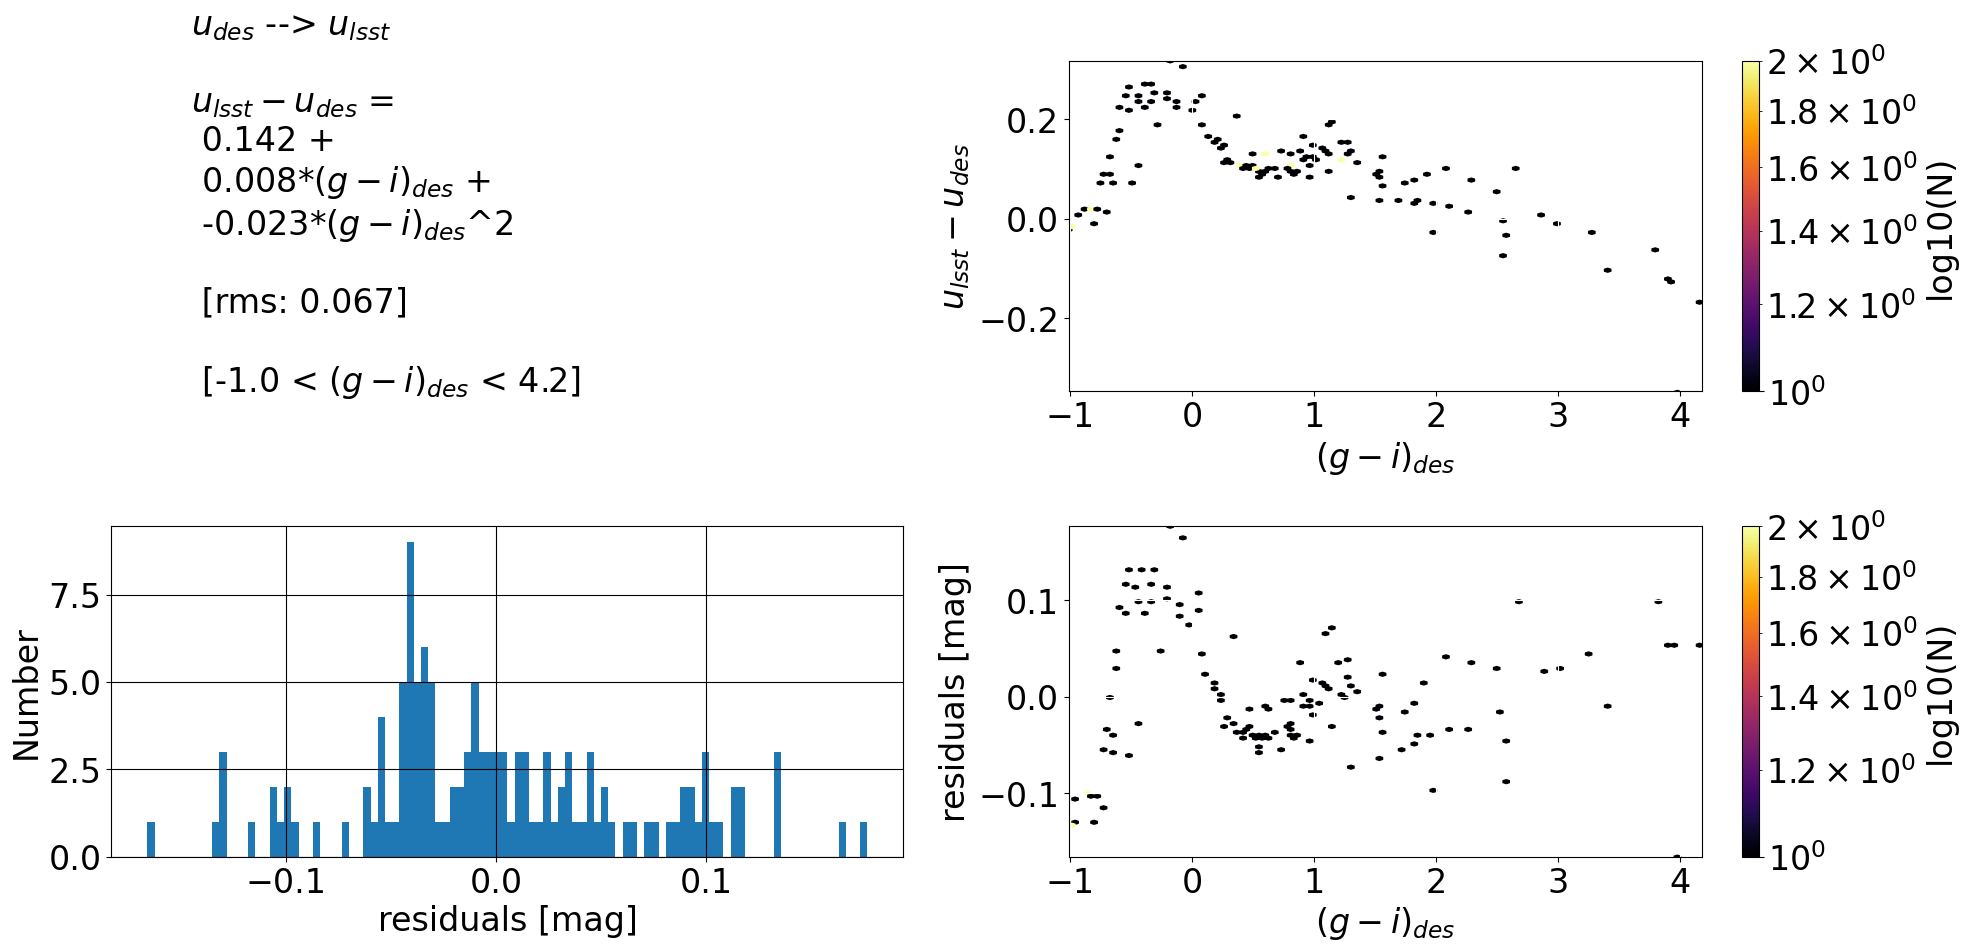

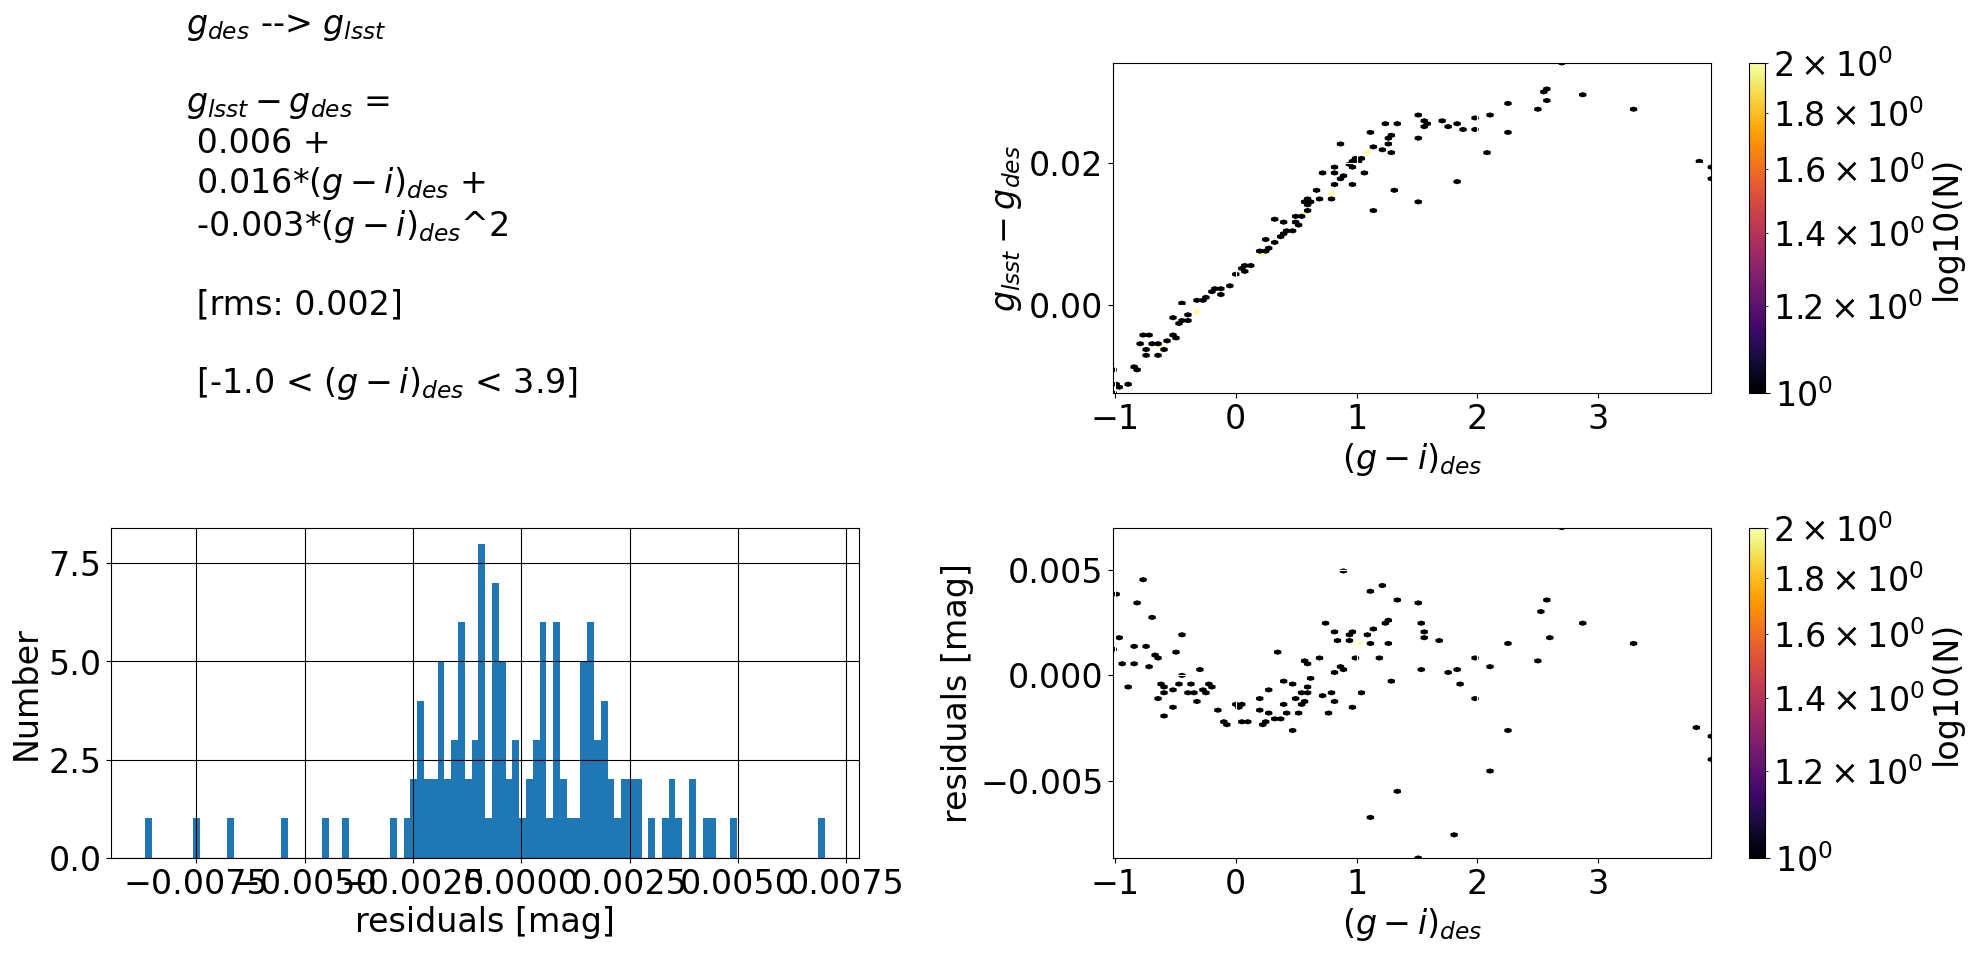

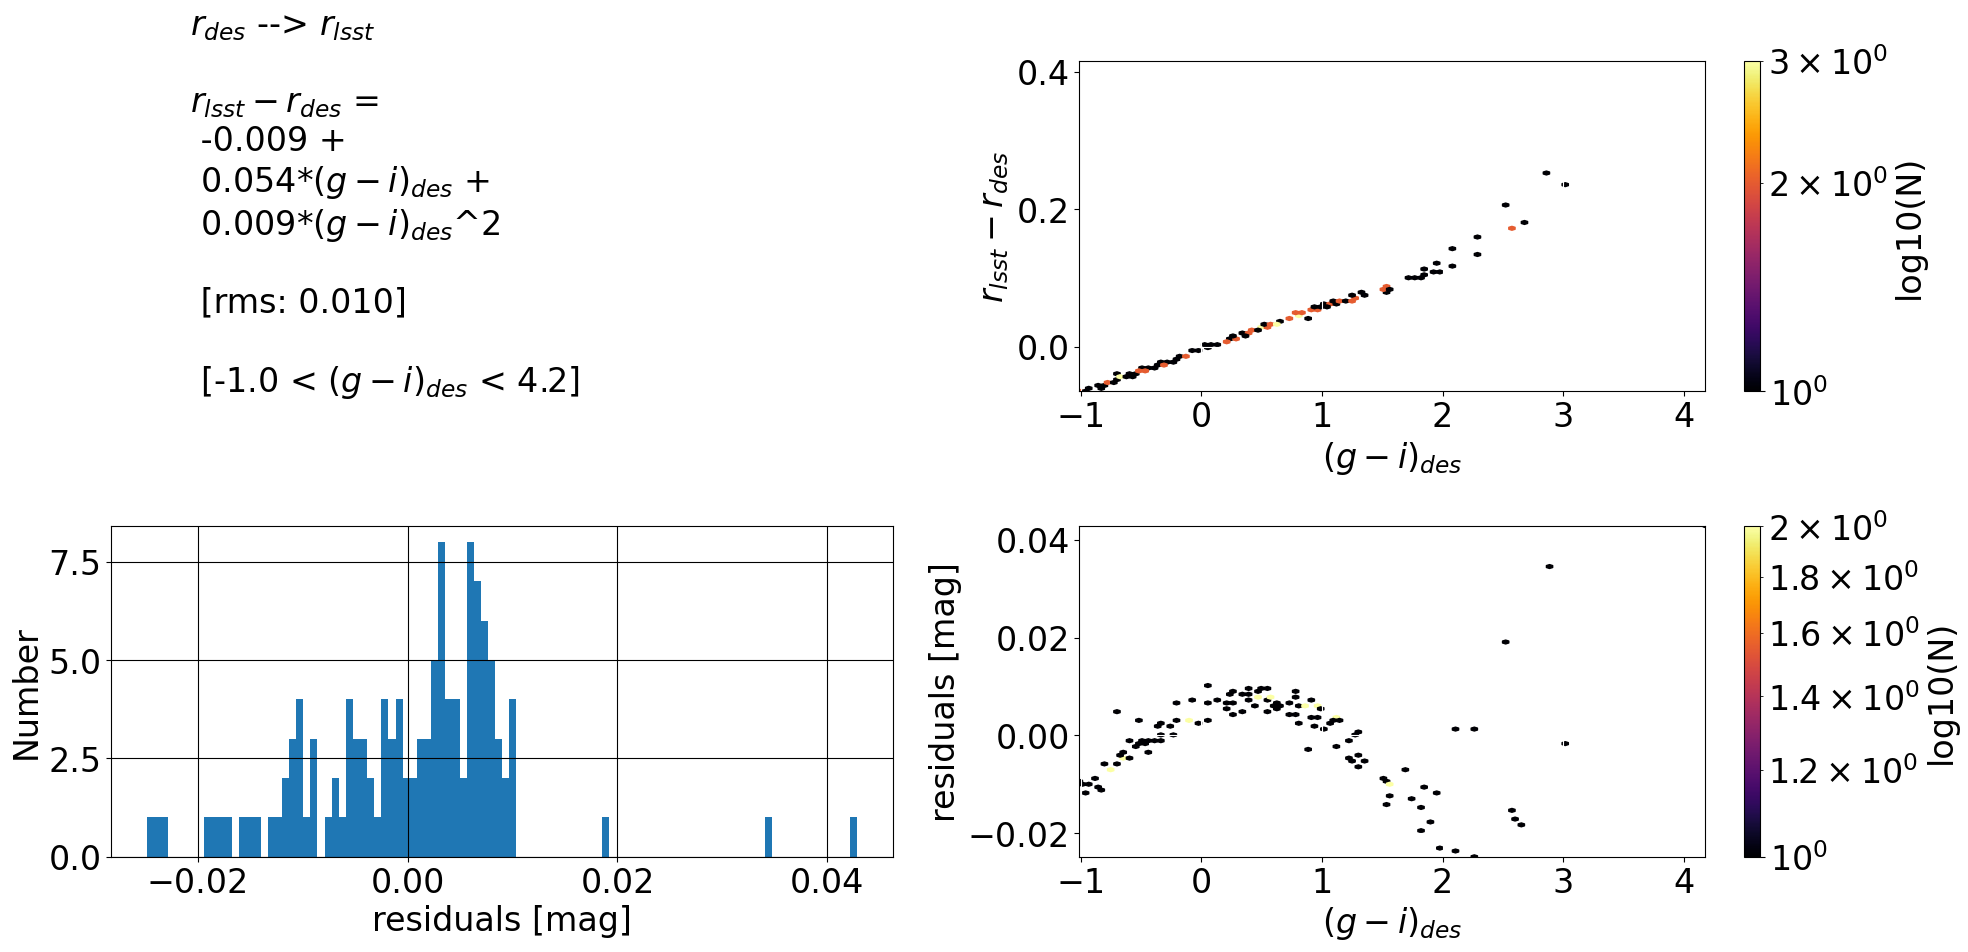

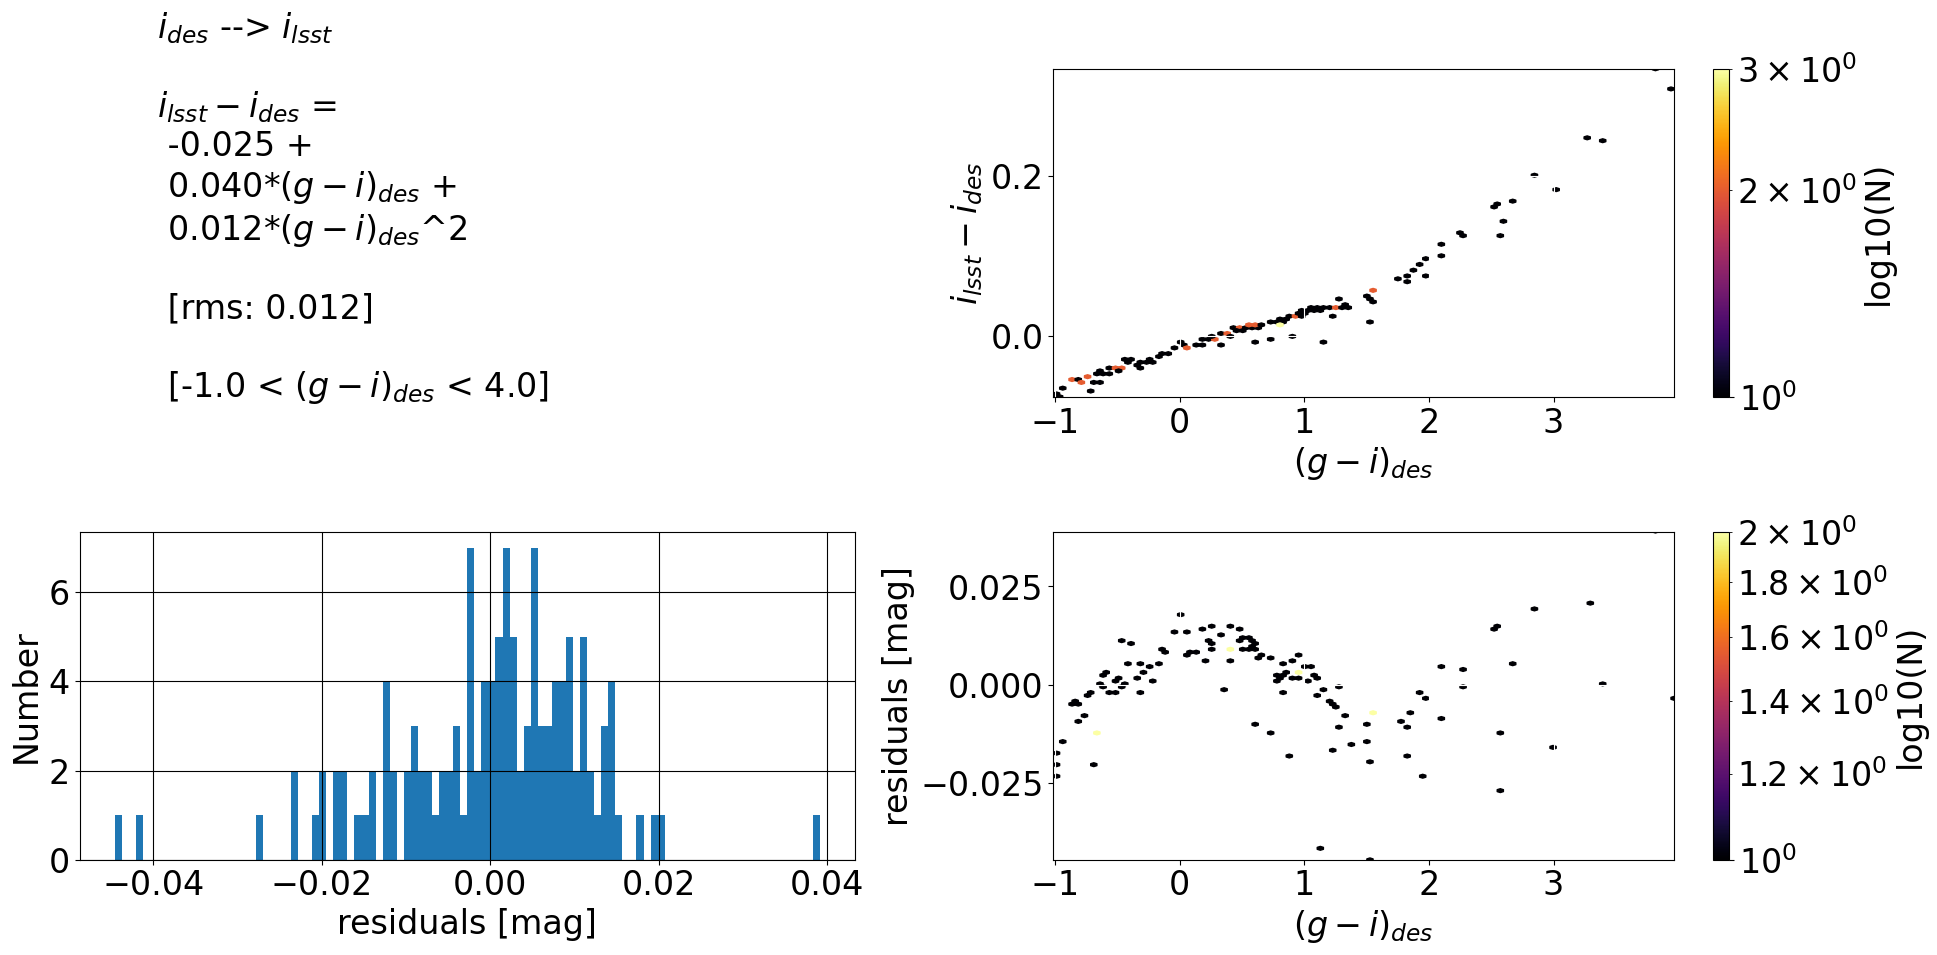

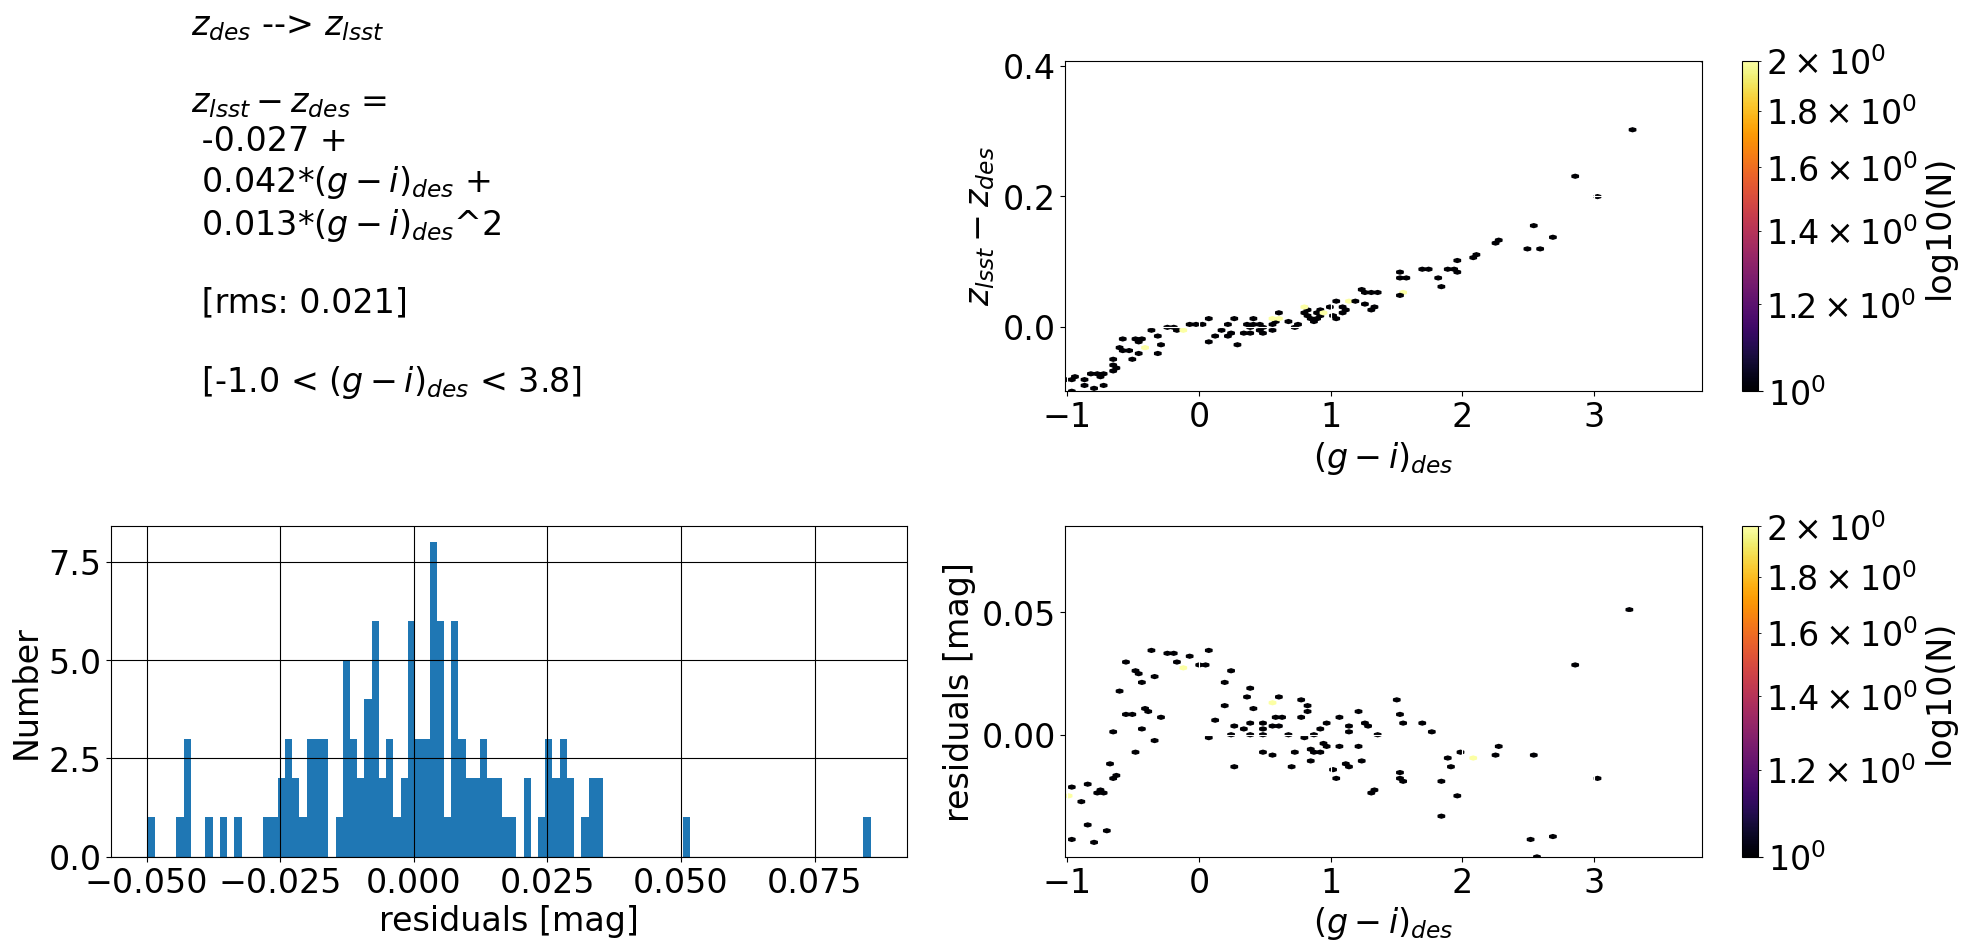

In [16]:
# Create results output file...
resultsFile = """%s.dmag.%s.norder%d.csv""" % (resultsFileBaseName, color_name_1, norder)

# Open fit results output file...
try:
    fout = open(resultsFile, 'w')
except IOError:
    sys.exit('Unable to write to file ' + resultsFile)

# Write header to fit results output file...
hdr = createFitResultsHeaderOutputLine(norder)
fout.write(hdr+'\n')

for band in bandList:
    
    print('')
    print('')
    print('')
    print("# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # ")
    print('band')
    print("# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # ")
    print('')
    
    magName_lsst = """%s_lsst""" % (band)
    magErrName_lsst = """%s_err_lsst""" % (band)
    magName_des = """%s_des""" % (band)
    magErrName_des = """%s_err_des""" % (band)
    
    # Grab the original version of df from the backup copy...
    df = df_orig.copy()

    # Grab the original version of mask from the backup copy...
    mask = mask_orig.copy()

    # Update dmag column for {$band}_lsst - {$band}_des...
    if toLSST:
        df.loc[:,'dmag'] = df.loc[:,magName_lsst] - df.loc[:,magName_des]
    else:
        df.loc[:,'dmag'] = df.loc[:,magName_des] - df.loc[:,magName_lsst]

    # Update mask...
    mask1 = abs(df['dmag']) <= 10.
    #mask2 = abs(df[magErrName_lsst]) <= 0.01
    #mask3 = abs(df[magErrName_des]) <= 0.02
    #mask = mask & mask1 & mask2 & mask3
    mask=mask1

    # Iterate, with sigma-clipping...
    for i in range(niter):

        iiter = i + 1
        if verbose > 0:
            print("""   iter%d...""" % ( iiter ))

        # make a copy of original df, overwriting the old one...
        df = df[mask].copy()

        # Identify dmag and color1 series...
        dmag =  df.loc[:,'dmag']
        color1 = df.loc[:,color_name_1]

        # Perform fit...
        p,perr,rms = transformFit1(color1, dmag, norder, verbose)
        df.loc[:,'res'] = residuals1(p, color1, dmag)

        # Identify outliers...|
        stddev = df['res'].std()
        mask = (np.abs(df.res)< nsigma*stddev)


    # Output results to the results file...
    outputLine = createFitResultsOutputLine(2, p, perr, rms, band, color_name_1)
    fout.write(outputLine+'\n')
    
    # Create title/names for use in QA plots...
    if toLSST:
        title = """$%s_{des}$ --> $%s_{lsst}$""" % (band, band)
        dmagName = """$%s_{lsst} - %s_{des}$""" % (band, band)
    else:
        title = """$%s_{lsst}$ --> $%s_{des}$""" % (band, band)
        dmagName = """$%s_{des} - %s_{lsst}$""" % (band, band)
        
    # Create QA plots...
    res =  df.loc[:,'res']
    outputFileName = """%s.dmag_%s.%s.norder%d.qa1.png""" % (qaFileBaseName, band, color_name_1, norder)
    status = transform1ColorQAPlots1(dmag, color1, res, norder, title, dmagName, colorLabel_1, p, rms, outputFileName)

fout.close()

In [17]:
#%ls -FlthrG

In [18]:
#%less transFit.ps1_to_des.dmag.gi_ps1.norder2.csv

In [19]:
# DES-->LSST:
# g vs. g-i (norder=1)
# r vs. r-i (norder=1)
# i vs. r-i (norder-1)
# z vs. r-i (norder=1)

In [20]:
# LSST-->DES:
# g vs. g-i (norder=1)
# r vs. r-i (norder=1)
# i vs. r-i (norder-1)
# z vs. r-i (norder=1)

In [21]:
%pwd

'/home/m/meaganp/WORK/github/KiwiTransforms/notebooks'

In [22]:
%ls -FlthrG

total 3.5M
-rw-r--r-- 1 meaganp   15 Mar 25 14:57 placeholder
-rw-r--r-- 1 meaganp 1.4M Mar 25 15:41 TransformationEquations_DES_ComCam.ipynb
-rw-r--r-- 1 meaganp 1.4M Mar 25 15:45 TransformationEquations_SynthLSST_DES.ipynb
-rw-r--r-- 1 meaganp 167K Mar 27 14:12 qaPlot.des_to_lsst.fit.dmag_u.gi_des.norder2.qa1.png
-rw-r--r-- 1 meaganp 178K Mar 27 14:12 qaPlot.des_to_lsst.fit.dmag_g.gi_des.norder2.qa1.png
-rw-r--r-- 1 meaganp 155K Mar 27 14:12 qaPlot.des_to_lsst.fit.dmag_r.gi_des.norder2.qa1.png
-rw-r--r-- 1 meaganp 152K Mar 27 14:12 qaPlot.des_to_lsst.fit.dmag_i.gi_des.norder2.qa1.png
-rw-r--r-- 1 meaganp 170K Mar 27 14:12 qaPlot.des_to_lsst.fit.dmag_z.gi_des.norder2.qa1.png
-rw-r--r-- 1 meaganp 1.1K Mar 27 14:12 transFit.des_to_lsst_g.dmag.gi_des.norder2.csv
